# Class 19: What To Do When Your Data Seems Too Big
Introducing a toolkit of solutions for dealing with bigger datasets and bigger problems.

## Preamble
1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Open up the Jupyter Lab server.
4. Run `git status` and `git add` and `git commit` anything that needs adding/committing.
5. Run `python3 git_fixer2.py`
6. Github:
    - git status (figure out what files have changed)
    - git add ... (add the file that you changed, aka the `_MODIFIED` one(s))
    - git commit -m "your changes"
    - git push origin main

## Goals of today's class
1. Practice running & editing scripts on Discovery proper (using VS Code & the shell / `srun` & `sbatch`)
2. Learn about parallelism and explore some Python-based solutions for parallelism
3. Discuss other techniques for dealing with big data/problems (like sparsification and GPU-based solutions)

## Connecting VS Code to Discovery
Y'all, I downloaded VS Code for you. I have not used a normal text editor in ages. I just have my emotional support vim. This is a big deal. 

### Getting VS Code Set Up
First, [download the VS Code](https://code.visualstudio.com/download#) that's appropriate for your machine. Hopefully you've already done this. Customize your theme (very important). Then install the Python, Jupyter Notebook, and Remote - SSH extensions. These will let you have Python syntax highlighting, use Jupyter notebooks in VS Code, and SSH onto Discovery via VS Code (and edit files etc. there). 

### SSH Tunneling Via VS Code
Next, click on the `Remote Explorer` tab on the left-hand side of your VS Code window. You'll see a plus sign; click on it. 
![](./images/vscode_remote_explorer_0.png)

This will pop up a little text box where you should type 

```
ssh YOUR_USERNAME@login.discovery.neu.edu
```

It will then ask you for your password; type that in and hit ENTER.

You should then be connected to your home directory on Discovery, where you can read & edit files to your heart's content.

You can also open up a terminal (which will start you out on a login node on Discovery) by clicking on `Terminal` and then `New Terminal`:

![](images/vscode_terminal.png)

## Running Scripts on Discovery

### The Basic Case
To request an interactive shell, we use `srun`. The basic syntax for `srun` is `srun --ntasks 1 --nodes 1 --cpus-per-task 1 --partition courses --mem=2G --time=00:30:00 /bin/bash`. A **task** refers to a computational process; you might have multiple tasks running at once, and each task might spawn multiple subprocesses. For now, we'll focus on the single-task case. A **node** refers to a machine, which may have multiple CPUs. We'll focus on the single-machine case for this lesson, as multi-node computation can get gnarly fast. `--cpus-per-task` tells us how many computing cores we'll want to use per task (this is useful for parallel processing, which we'll discuss later today). And then the **partition** refers to the section of the cluster we're running the code on; this might be `courses` or `courses-gpu`, for example. `--mem` indicates how much RAM we're requesting, and `--time` is how long we want to use the shell for (the upper limit is 24 hours). Finally, we're requesting a `/bin/bash` shell, which will let us run a Python script (for example). 

This lets us run code and watch it progress; however, if we log out of Discovery or our time runs out, we can say goodbye to any progress we've made running the script!

### Fancier Cases
We can also submit jobs to the cluster to execute without our direct supervision (i.e. not interactively) using `sbatch`. In order to do this, we write a **shell script**, which is a program that's designed to be executed by the command line (the Unix terminal). Here's an example shell script for `sbatch`:

```
#!/bin/bash                                 # this is in the bash scripting language
#SBATCH -J alyssa_is_trying_to_run_code     # Job name
#SBATCH -N 1                                # Number of nodes
#SBATCH -n 1                                # Number of tasks
#SBATCH --cpus-per-task 10                  # CPUs per task
#SBATCH -o output_%j.txt                    # Standard output file
#SBATCH -e error_%j.txt                     # Standard error file
#SBATCH --mail-user=smith.alyss@northeastern.edu  # Email
#SBATCH --mail-type=ALL                     # Type of email notifications

module load anaconda3/2022.05               # loading conda
module load openmpi/4.0.5                   # loading openMPI to run python MPI code
mpirun -np 10 /courses/PHYS7332.202510/shared/phys7332-env/bin/python mpi_rumor.py         
# ^ run a Python script that uses MPI
```

When we submit this, we can see our code's output at `output_{job_name}.txt` and any errors at `error_{job_name}.txt`. We'll also get email notifications about our code running, breaking, and finishing. We can set the number of nodes/tasks/CPUs per task (and more), just as we did with `srun`. And if we set our code to save output files and any other results, we can run big computations without babysitting the cluster very much at all.

We can also monitor the status of our jobs with `squeue -u {your_username}`. 

### Practice!!
The [**rumor model**](https://en.wikipedia.org/wiki/Rumor_spread_in_social_network) is a toy model that can be used to simulate how rumors spread in a network. It's governed by two parameters, $\alpha$ and $\beta$. We'll be coming back to this model throughout today's lesson. Essentially, there are 3 states: **S** (**spreader**, or "infected"), **I** (**ignorant**, or "susceptible"), and **R** (**recovered**, or a "stifler"). 

When an "ignorant" person meets a spreader, then with probability $\alpha$, the "ignorant" person becomes a spreader as well. 

When two spreaders meet, with probability $\beta$, one of them becomes a stifler. 

And when a spreader and a stifler meet, then the spreader becomes a stifler with probability $\beta$. 

Today we're going to practice simulating the rumor model in a variety of ways; some will work better than others. First, though, let's try running a very basic **agent-based** version of the rumor model in a Python script using `sbatch`. I've provided a starter script for you to run; it's in `scripts/rumor.py`. The example `sbatch` script can be found in `scripts/sbatch_template.sh`. You'll need to change the absolute filepath of the Python script, as well as some of the email options, in the `sbatch` script. This is a great opportunity to practice navigating the filesystem and editing files in VS Code!!

Once the script is done running, we'll load the results and plot them. 

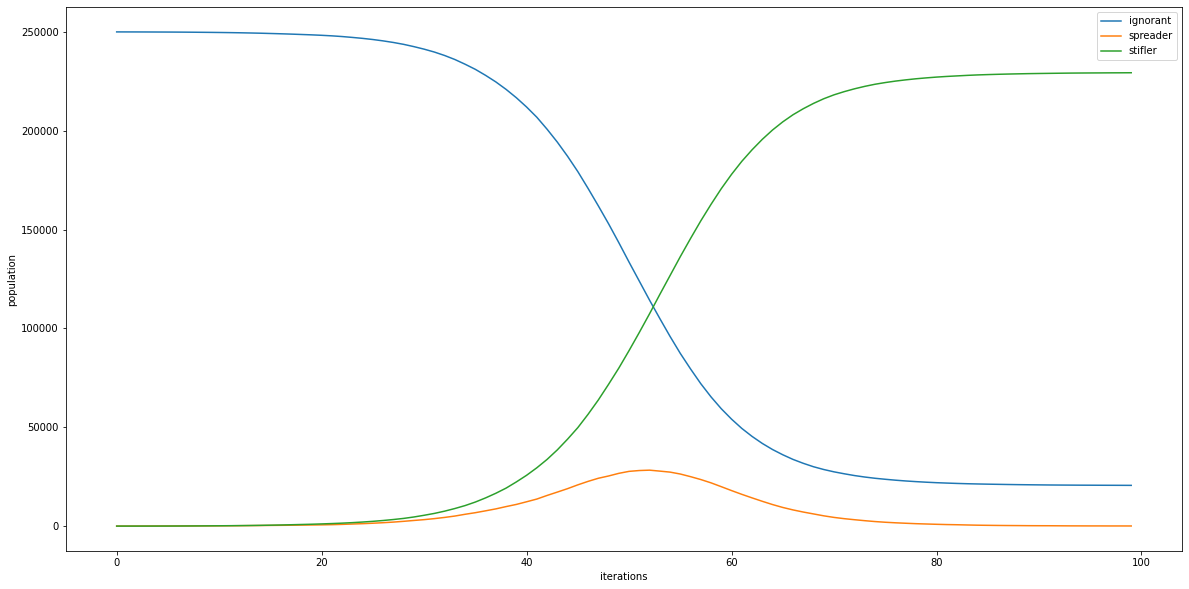

In [32]:
import pickle
import collections
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
dset = pickle.load(open('./rumor_model_agent_based.pkl', 'rb'))

counts = [collections.Counter(idx.values()) for idx in dset]

ignorant = [c['ignorant'] for c in counts]
spreader = [c['spreader'] for c in counts]
stifler = [c['stifler'] for c in counts]

plt.plot([i for i in range(len(counts))], ignorant, label='ignorant')
plt.plot([i for i in range(len(counts))], spreader, label='spreader')
plt.plot([i for i in range(len(counts))], stifler, label='stifler')
plt.xlabel('iterations')
plt.ylabel('population')
plt.legend()

### Interlude
You might've noticed that that took a long time to run; moreover, we only got one run of the model for all that waiting. There are some easy ways that we can get more data (maybe a sense of how much variation there will be in rumor spreading trajectories over several runs, perhaps?) -- what do you think we could try?


## Jupyter Lab on computing nodes
**This section is by [Minami Ueda](https://minamiueda.com); you can find more of Minami's excellent documentation [on his website.](https://minamiueda.com/docs/)**


You can run your own Jupyter Lab for yourself, without depending on the OOD.



### Getting computing nodes
Let's start by getting a computing node allocated. Why computing nodes? As the name tells, the login nodes are designed exclusively for "login" purposes, and thus any computations should be done on computing nodes.

First, either in the shell of your login node, create a new batch file as following. This batch file specifies the options for the computing node, starts `tmux` and keeps the job running until the time limit. `tmux` is a terminal multiplexer that allows you to run use multiple panes and tabs in command line interface, and also keeps the session running in the background even when you close the screen (detach the session).

Save this as `~/tmux-jupyter.sh`. Make sure to modify `USERNAME` to yours.

```bash
#!/bin/bash
#============ Slurm Options ===========
#SBATCH --partition=courses
#SBATCH --mail-user=your_email@northeastern.edu
#SBATCH --mail-type=END
#SBATCH --time=4:00:00
#SBATCH --cpus-per-task=4
#=======================================

# Clear current env/modules
module purge

# Load required module from Discovery
module load discovery
module load anaconda3/2022.05

# Activate any necessary environments
source activate /courses/PHYS7332.202510/shared/phys7332-env/

# Move to your directory
cd /courses/PHYS7332.202510/students/USERNAME/

# Start tmux session with name "0"
tmux new -d -s "0"

sleep infinity
```

Once you've created the batch file, let's submit the job. This batch file will request for a computing node with the options we've specified, and if that's accepted by the system, a new tmux session will start up in the allocated node.

```sh
sbatch tmux-jupyter.sh
```

Let's check that if the batch has been processed properly, using the `squeue` command. If the `ST` column is `R`, it means that the job is running.
```shell-session
$ squeue -u $USER
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1234567 express       tmux.sh  john R    00:59:30      1 c0001
```

After confirming that the job is running, you can enter the shell by "attaching" to the tmux session with the `srun` command. This will open up a `tmux` screen. (Job ID is shown in the output of the `squeue` command.)
```sh
srun --jobid=<your_job_id> --pty tmux a
```

Once entering the shell, the prompt would tell you the hostname of the node that you were allocated to. In the following example, you are allocated to node `c0001`. For Discovery, the hostname for computing nodes are `cXXXX` where `XXXX` is a four-digit number.
```shell-session title="Shell prompt in the allocated node"
[john@c0001 ~]$
```

Ensure you detach (`<tmux_prefix> d`) when you finish using it instead of killing the shell. By default, the tmux prefix is set to `Ctrl-b`. To detatch, you first push `Ctrl-b` first, release the keys, and then type `d`.



### Connecting VS Code to the Computing Node

Open a new VS Code window, click on the `Remote Explorer` tab on the left-hand side of your VS Code window. Beside the plus sign that we've used for the previous steps (above), there's a "gear" icon to open a SSH config file. Click on it, and select the top item (usually `/User/username/.ssh/config`) in the menu.

![](images/vscode_remote_ssh_select_ssh_config.png)

Add the following lines to the editor and save. Make sure that you modify these to match yours.
- Username
- Hostname of the computing node (`c0001`) to match the node that you've been allocated to
- Path to the SSH private key (identity file)

Hostname of the computing node is usually a 5 digit text with `cXXXX`, where `XXXX` part is the numbers. Go back to the login node terminal and check yours.

```txt
# Login node
Host discovery
    HostName login.discovery.neu.edu
    user john
    IdentityFile ~/.ssh/id_ed25519
  
# Computing node: Note that each computing node needs separate configs
Host c0001
    HostName c0001
    user john
    IdentityFile ~/.ssh/id_ed25519
    ProxyCommand ssh -W %h:%p discovery
```

Once you save the file, `discovery` and `c0001` (or whatever node that you've added) should be available in the Remote Explorer (the panel on the left). Click on the arrow besides `c0001` to connect.

If this is your first time connecting to Discovery from VS Code, it might take some time (possibly more than 20 minutes) to download the "VS Code Server" which is the counterpart software on the remote server to establish a connection with the client.

![](images/vscode_remote_ssh_downloading.png)


Once the initial download of VS Code Server is complete, it might show a popup confirming that the OS version is unsupported. You can ignore this, so click "Allow."

![](images/vscode_remote_ssh_unsupported.png)


### Starting Jupyter Lab

Once the connection to the computing node is established, navigate to the terminal on the bottom of the windoe and attach to the tmux session running.

```sh
tmux a
```

Then, type in the following command to start the Jupyter Lab.
```sh
jupyter lab --no-browser
```

 After a while, it should show URLs starting with `http://localhost:<some_port>`. Keep this URL somewhere because we will use it later.

### Optional: Setting up port-forwarding to access from a browser
(Skip this section if you don't need a browser access to Jupyter Lab.)

How do we use the Jupyter Lab that we've launched on the computing node? By default, you cannot access it even if you type in that Jupyter URL (i.e., `http://localhost:8888`) on your browser. It's running at the `localhost` on the computing node, not your local machine.

**Port-forwarding** is the technique that we use to solve this issue. As the term tells by itself,**we forward the ports on remote servers to ports on our devices**, so that `http://localhost:8888` (or any other ports) on local devices points to what's available on the server. The connection is provided by SSH, which means that everything that is transferred is encrypted using cryptographic algorithms.

While you would usually have to type in a long `ssh` command to forward ports, you can do this in a single click if you have connected VS Code to the computing node using the `Remote - Tunnels` extension. It's even possible that the extension does it for your self automatically when you start a Jupyter Lab, as you can see in the following screenshot.

![](images/vscode_remote_start_jupyter_port.png)

To manually setup port-forwading on VS Code, push `Command+Shift+P` to open the Command Pallette. Start typing in "Toggle Ports". Click on `View: Toggle Ports`. This should show a "port panel" on the bottom of the window.

Click on the `Forward a Port` button, add fill in the following information.
- Port: `8888` (or other port where Jupyter Lab is launched at)
- Forwarded Address: `localhost:8888`

Once you've enabled portforwarding, you should finally be able to access Jupyter Lab on your machine. Type in `http://localhost:8888` in the browser. When the Jupyter asks for a token or a password, run the following in the terminal of the computing node.

```shell-session
$ jupyter server list

Currently running servers:
http://localhost:8888/?token=TOKEN_IS_PRINTED_HERE :: /home/john
```

Copy and paste the token from the URL and click "Log in."


### Opening a Jupyter notebook

In the explorer (left pane of the window) on VS Code, open your class directory. The path should be something like: 
```
/courses/PHYS7332.202510/students/your_name/student-network-science-data-book/
```

Click on the Jupyter notebook file (a file with extension `.ipynb`) that you want to open. You might need to install `Jupyter` and `Python` extension for VS Code on the server.

Once the notebook is open, click on the `Select Kernel` button, that is shown on the top of the notebook. Click on `Existing Jupyter Server...` in the menu.

In the textbox, copy and paste the full Jupyter URL that we've kept a note of. It can be confirmed in the tmux session (e.g., `http://localhost:8888/?token=YOUR_TOKEN`), or if the URL has gone somewhere after many lines of logs, you can use the following command.
```sh
jupyter server list
```

After pasting the Jupyter URL into the textbos, press the enter key for the remaining confirmation popups.

You should now be able to run the cells in the Jupyter notebook! (The first cell run could take some time to start the kernel.)


## Parallelism
Enter parallelism: the act of doing more things at the same time (and hopefully not ending up with more problems as a result)!

### What is parallel processing?
Parallel computing is when we have multiple computational processes running at the same time. For example, say I have 4 loads of laundry. I could run 4 loads of laundry sequentially, using one machine 4 times, or I could be a slightly bad apartment citizen and use both of our building's two machines at the same time. In this case, I'm still doing 4 loads of laundry, but they get done in the time it takes two cycles to run. The same logic underlies parallel computing. 

We can see parallel computing in action with a `pytorch` [data loader](https://www.geeksforgeeks.org/how-the-number-of-workers-parameter-in-pytorch-dataloader-actually-works/#understanding-the-role-ofnum_workers) object; these usually pre-fetch the next batch(es) of data while the model is training on the batch that was just loaded. Or we can, in a less complicated case, run a bunch of the same randomized simulation at once; this lets us get more information about, say, a dynamical process on a network. 

In general, we want to break the problem we're solving down into discrete chunks of work that can be done concurrently. For example, I might sort my laundry into loads, all of which need to be washed, then dried. If I have 4 washers, 4 dryers, and 4 loads of laundry, I can first put each load through a wash cycle, then take each load out of the washer, put it in the dryer, and run it through a dry cycle. This takes me the length of one wash cycle and one dry cycle to do all my laundry. If I were to do this entirely serially, it would take me 4 wash cycles and 4 dry cycles to finish my laundry. I could also parallelize somewhat with one washer and one dryer by washing one load and drying another at the same time. 

#### When is it useful? When is it terrible?
Sourced from Quentin F. Stout's ["Not Too Serious Explanation"](https://web.eecs.umich.edu/~qstout/parallel.html) of parallel computing. 

Again, speaking generally, parallelism is more useful when your processors do less waiting around. Some tasks are what's called *embarassingly parallel*; an example would be me washing my 4 loads of laundry. If I had 4 loads and 4 machines, I could get all my laundry washed at once. The loads don't depend on each other, and they don't have to pass information back and forth between each other. I also don't have to combine any information at the end; I just haul my laundry upstairs. Embarassingly parallel tasks are so named because it would be embarassing to not parallelize them. 

You also might have tasks that take different amounts of time but don't really interact. This could be computation jobs on a cluster or people lined up to do laundry loads that take varying amounts of time (there's a delicates cycle, a heavy cycle, and the normal one I use by default because I can't be bothered to properly sort my laundry). We can deal with these with a single queue/multiple worker paradigm, where jobs get done as resources become available. There's also a multiple queue/multiple worker paradigm, which is how the checkout lines at grocery stores function (this is not as efficient).

And finally, you might have a single task that takes a long time, so you do the work of breaking it into discrete pieces that can be done at the same time. If some pieces of work *just take a long time*, you might have a lot of workers waiting around doing nothing while waiting for the task results they depend on to show up. The example Stout uses is building a house; putting in the foundation is going to take a long time, and you need the foundational because it's, you know, foundational to the rest of the house. 

Tasks like building a house (metaphorically) are less parallelizable and incur a lot of overhead work in breaking them up to make them parallelizable in the first place. So they might be less ideal candidates for parallel computing. 

### MPI and `mpi4py`
MPI, or Message-Passing Interface, is a **standard** that allows parallel processes to pass messages to each other. Each computing node/process has its own memory; it doesn't know what the other nodes are doing or what information they have. Multiprocessing often uses a SPMD model (single program multiple data) model -- this is when each processor works on a different chunk of data, such as when each core of a GPU does part of a matrix multiplication. 

We're going to work with MPI using the `mpi4py` package. `mpi4py` lets us use MPI with Python bindings. 

First, let's try some basic MPI commands. Here's some Python code; make a `.py` script in VS Code on Discovery that contains this code. 

```
from mpi4py import MPI

rank = MPI.COMM_WORLD.Get_rank()
n_ranks = MPI.COMM_WORLD.Get_size()

print("Hello World! I'm rank", rank);
print("Total no. of ranks =", n_ranks);

```

Next, we'll run the following:
```
module load openmpi/4.0.5
mpirun -np 4 /courses/PHYS7332.202510/shared/phys7332-env/bin/python SCRIPT_NAME.py
```

Here, we're loading the MPI module and then running (with the Python in our shared class environment) the script we just made. 

#### Interactive Moment
What output do you see? What does this mean?


#### Running A Bunch of Rumor Models
Now let's try running a bunch of rumor model agent-based simulations at once. To do this, we'll use `scripts/sbatch_mpi.sh` and `scripts/mpi_rumor.py`. Take a look at these scripts; you'll notice that they don't differ much from `scripts/sbatch_template.sh` and `scripts/rumor.py`. The only difference is that they incorporate MPI and `mpi4py`; for the Python script, this means that we need to have `mpi4py` installed in our Python executable (that's why we're specifying our course environment, which conveniently has `mpi4py` installed) and we need to keep track of what our **rank** is so that we write multiple files with unique names (instead of one that has the same name for each process). In the shell script, we need to load the MPI module and then run our script using the `mpirun` command:

```
mpirun -np 10 /courses/PHYS7332.202510/shared/phys7332-env/bin/python mpi_rumor.py
```

Let's see how many pickle files we get!

Then we'll load our pickle files and see how much variation we have in our spreading processes.

In [34]:
import glob

ignorant_all = []
spreader_all = []
stifler_all = []
for fname in glob.glob('./scripts/rumor_model_agent_based_process_*.pkl'):
    dset = pickle.load(open(fname, 'rb'))
    
    counts = [collections.Counter(idx.values()) for idx in dset]
    
    ignorant_all.append([c['ignorant'] for c in counts])
    spreader_all.append([c['spreader'] for c in counts])
    stifler_all.append([c['stifler'] for c in counts])


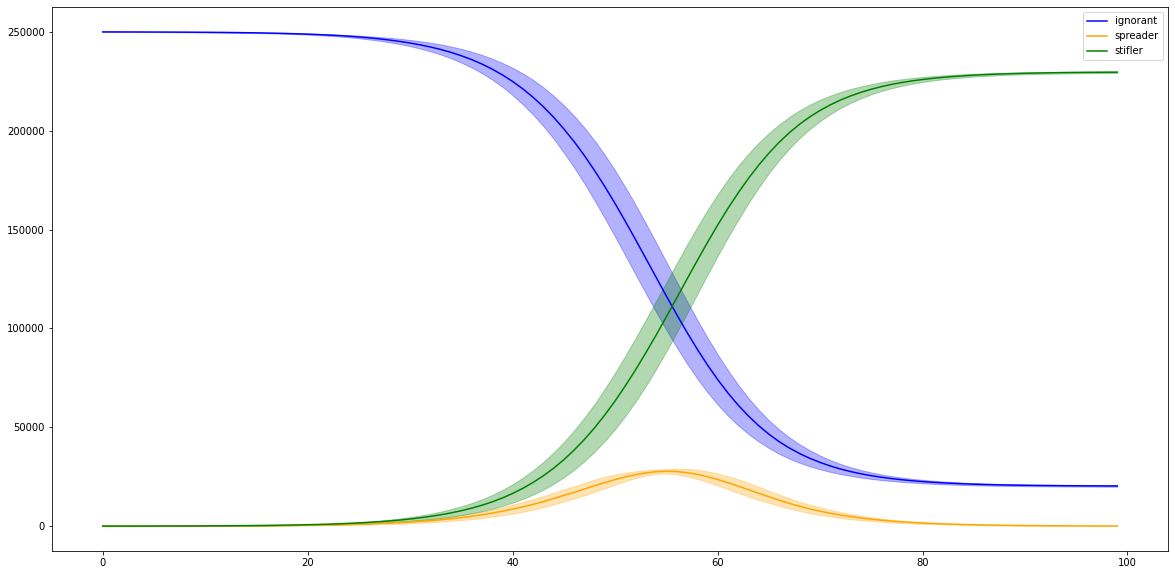

In [33]:
import numpy as np

ignorant = np.array(ignorant_all)
spreader = np.array(spreader_all)
stifler = np.array(stifler_all)

for ls, color, label in [
    (ignorant, 'blue', 'ignorant'), 
    (spreader, 'orange', 'spreader'), 
    (stifler, 'green', 'stifler')]:
    ls = ls[:, :100]
    plt.fill_between(
        list(range(ls.shape[1])), 
        np.mean(ls, axis=0) - np.std(ls, axis=0),
        np.mean(ls, axis=0) + np.std(ls, axis=0),
        color=color,
        alpha=0.3)
    plt.plot(list(range(ls.shape[1])), np.mean(ls, axis=0), color=color, label=label)
plt.legend()

#### MPI, But Fancier
What about the actual message-passing that was promised with MPI? Let's look at some examples.

Here, we're going to send data (in the form of Python objects, which can be pickled) from one process to another. If our process has rank 0, we **send** data, and if it's rank 1, we **receive** data from process 0. Note that there's a tag on the sent & received messages; this can be useful when we're expecting multiple messages from another process and need a particular one to continue.

```
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = {'a': 7, 'b': 3.14}
    comm.send(data, dest=1, tag=11)
elif rank == 1:
    data = comm.recv(source=0, tag=11)
```
 
We can also send buffered objects, like `numpy` arrays, with capitalized versions of the same functions (like `comm.Send` and `comm.Recv`).

```
from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# passing MPI datatypes explicitly
if rank == 0:
    data = numpy.arange(1000, dtype='i')
    comm.Send([data, MPI.INT], dest=1, tag=77)
elif rank == 1:
    data = numpy.empty(1000, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)

# automatic MPI datatype discovery
if rank == 0:
    data = numpy.arange(100, dtype=numpy.float64)
    comm.Send(data, dest=1, tag=13)
elif rank == 1:
    data = numpy.empty(100, dtype=numpy.float64)
    comm.Recv(data, source=0, tag=13)
```

Additionally, we can have one process be the leader/"root" and broadcast information to, or collect information from, the others (who are usually referred to as "workers").

```
from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = {'whales': True}
else:
    data = None

print('I am process ', rank, 'and my data is ', data)

data = comm.bcast(data, root=0)
print('I am process ', rank, 'and my data is now ', data)

ranks = comm.gather(rank, root=0)
if rank == 0:
    print('I am process ', rank, 'and the ranks of all processes are ', ranks)
```

Let's try running this code; it can be found in `scripts/test_mpi.py`. 

First we'll request a session with 4 cores:

`srun -n 4 --pty /bin/bash`

Then we'll run our code:

`mpirun -np 4 /courses/PHYS7332.202510/shared/phys7332-env/bin/python test_mpi.py`

### An Adventure with K-Means and MPI
Now we're going to try a slightly fancier MPI experiment. In the `scripts` folder, you'll find a file named `kmeans_mpi_skeleton.py`. It contains skeleton code for running the k-means algorithm in a parallelized fashion. All processes know about a shared array of centroids (this is computed by the leader process). Each process then deals with one chunk of the points in the dataset; it assigns each point it knows about to a centroid. Once it's done that, it counts how many points are assigned to each centroid; for each centroid, it takes the average of the points assigned to that cluster. Then the leader process gathers all the point counts and cluster averages from the workers; for each centroid, it computes the global average of all points assigned to that centroid. The leader process also keeps track of the total Euclidean distance of all points from their closest centroid; when this converges, the algorithm terminates. 

There are lines marked `#TODO: `; these are for you to fill out! Spend some time working through the code in pairs or small groups. Just shout if you have any questions! You can run this code using 

`mpirun -np 4 /courses/PHYS7332.202510/shared/phys7332-env/bin/python kmeans_mpi_skeleton.py`


## Other Techniques for Big Data Problems: Lightning Round
### Hadoop & MapReduce
MapReduce is a way to think about parallel computing. First, we run a **map** procedure that does sorting or filtering (or some combination thereof). Next, we run a **reduce** procedure that takes the worker processes' output and performs a summary operation on it. For example, in our k-means example from above (which does not perfectly obey the MapReduce paradigm), the **map** step would roughly map to the parts where all processes figure out which nodes belong to which clusters and compute their own cluster means. Then the **reduce** step would occur when the leader process makes the new centroids and calculates the overall score. 

Here's the overall sequence *(with examples from our k-means implementation):
1. Assign data to workers for the `map` step *(we split up the data points in our dataset for k-means)*
2. Each worker executes the `map` code on the data given to it *(workers assign their points to clusters and compute centroids for the points they know about)*
3. Workers send their output to the processor(s) doing the `reduce` step *(the root/leader process collects the computed centroids and point counts per centroid)*
4. The processor(s) doing the `reduce` step execute the `reduce` code *(the leader process computes the new centroids and decides whether to keep iterating)*
5. We produce the final output *(the program terminates and prints out the final centroids)*

#### Interactive Moment
Let's say we were trying to count words in a set of documents. How could we do this using MapReduce?

#### How is MapReduce used today?
(borrowed from [AWS](https://aws.amazon.com/what-is/hadoop/))
Hadoop (by Apache) is an open-source framework for dealing with big data. It consists of 4 parts:
- HDFS: Hadoop Distributed File System. Stores files in a redundant, distributed fashion.
- YARN: Yet Another Resource Negotiator. Wrangles the compute nodes and keeps track of cluster usage.
- MapReduce: Our new friend, as detailed above.
- Hadoop Common: provides common Java libraries for usage across all modules. 

Hadoop has a bunch of applications you might've heard of before, including Spark (distributing processing with all sorts of cool optimizations for graph data, NLP, machine learning, and more) and Hive (does MapReduce with a SQL interface). It is open-source, tolerant of machines breaking down, and does not require specialized hardware to run. You might encounter it working in any industry setting where they have more data than they know how to deal with. 

### GPUs & Friends Are Cool
GPUs can be used to accelerate lots of computational problems. [FAISS](https://github.com/facebookresearch/faiss/wiki/Faiss-on-the-GPU), or Facebook AI Similarity Search, is a fast library for clustering and nearest-neighbor search; it optionally uses GPUs to speed up searching for similar data points in enormous datasets. 

The Python `numba` package supports GPU accleration and is also very fast on CPU due to parallelism under the hood; it does a lot of the functionality that `numpy` has, and it is therefore useful for scientific computing type operations. Similarly, `cuPy` offers GPU accleration for work that can also be done in `numpy` and `scipy`. NVIDIA, our GPU-making friend, offers a package/ecosystem called `RAPIDS` that offers GPU-based acceleration for dataframes, graph data science work, machine learning (`cuML` is analogous to `scikit-learn`), and even spatial analysis (`cuSpatial`). 

And of course, there's `cuGraph`, which is analogous to `networkx` with similar functionality. You may also have some luck running somewhat large network computations using `igraph` instead of `networkx`; `igraph` uses C under the hood, so it tends to run faster and be more efficient than `networkx` is. 

The `dask` package offers parallelism and distributed computation for `pandas` dataframes, and it supports `cuPy` computation, courtesy of NVIDIA again, on its dataframes. 


## Zombies!
First, some less exciting information that scaffolds your zombie-related task:

### Bash for loops
In our `.sh` files above, we didn't do anything super fancy. We declared some variables for `sbatch` and then called up some modules and ran our script. However, we can do some fancier things in bash! This is how you write a for loop in bash:
```
#!/bin/bash
for i in 1 2 3 4 5
do
   echo "Welcome $i times"
done
```

We're making a sequence of parameters (we can also use `for i in {0..10..2}` to iterate from 0 to 10, incrementing by 2 each time) and then running a bash command (`echo`) with a different value of `i` each iteration. 

### Command Line Arguments for Python scripts
You may have seen programs that take command line arguments (perhaps you've used `ssh -vvv username@server` to debug an SSH connection; the `-vvv` flag indicates the level of detail in which the system reports on what it's doing). We can also do this with Python scripts using the `argparse` package. Here's an example use case for `argparse`:

```
import argparse
import random

WHALES = ['orca', 'blue whale', 'fin whale', 'sei whale', 'beluga', 'narwhal', 'minke whale']
SHARKS = ['tiger shark', 'wobbegong', 'carpet shark', 'pyjama shark', 'great white shark']
parser = argparse.ArgumentParser()
parser.add_argument("--whales", help="how many whales do you want me to print?", type=int)
parser.add_argument("--sharks", help="how many sharks do you want me to print?", type=int)
parser.add_argument("--double", help="doubles the number of whales and sharks printed", type=bool)
args = parser.parse_args()

if args.whales:
    n_whales = args.whales
else:
    n_whales = 0

if args.sharks:
    n_sharks = args.sharks
else:
    n_sharks = 0
    
if args.double:
    n_whales *= 2
    n_sharks *= 2
    
return_whales = []
if n_whales > 0:
    for ix in range(n_whales):
        return_whales.append(random.choice(WHALES))

return_sharks = []
if n_sharks > 0:
    for ix in range(n_sharks):
        return_sharks.append(random.choice(SHARKS))
        
print(return_whales)
print(return_sharks)
```

I would then run this script using `python3 argparser.py --whales 5 --sharks 2 --double True` (or a similar call). You can find this script in `scripts/argparser.py`. 

### Zombies, for real!
To conclude class, let's write an agent-based simulation model for a zombie apocalypse. We can use our rumor model code as a template. Here are the rules:

1. We start off with `n_seeds` individuals who are infected with the zombie virus. 
2. With probability $\beta$, individuals with a connection to a zombie are in danger of being bitten. With probability $\alpha$, which should be quite small, the individual in danger of being bitten instead slays the zombie. Otherwise, the individual is in fact bitten.
3. Slain zombies are permanently dead. They cannot infect others. 
4. At each time step after a successful zombie bite, individuals who were bitten by a zombie have a $\delta$ chance of dying (temporarily; this is but a stop on the journey to becoming undead).
5. A dead individual cannot interact with other individuals (because they are deceased)
6. Once an individual dies temporarily, they have a $\gamma$ chance, at each time step, of resurrecting and becoming a zombie (i.e. undead and infectious). 

We have 5 states: 
- zombie (undead)
- susceptible (not bitten; not temporarily dead; not undead; not perma-dead)
- bitten (bitten by a zombie; not yet temporarily dead)
- dead, temporarily (bitten by a zombie & died for a bit)
- perma-dead (you are a zombie that was slain by a susceptible individual).

Your mission, should you choose to accept it, is to code up an agent-based zombie simulation and execute 10 or so parallel runs of the zombie simulation. Keep track of the number of individuals in each state at each time step and plot the results. Extend the `sbatch_mpi.sh` script to iterate over a list of parameters for one of the variables, and produce data files whose names reflect the parameters used. Compare your results with others as you vary the parameters. 